# **Facial Emotion Classifier**

## Project Content <a id = 0></a>

### First Step: First Organization

1. [Introduction](#1)
2. [Loading libraries and packages to embark our new journey](#2)
3. [Checking The Dataset](#3)
4. [Creating a Data Pipeline to Load The Dataset](#4)

### Second Step: Data Preprocessing

5. [Scaling The Dataset](#5)
6. [Splitting The Data](#6)

### Third and Final Step: Modeling

7. [Defining The Modeling Functions](#7)
8. [Building The Model's Architecture](#8)
9. [Training](#9)
10. [Loading The Model and its History](#10)
11. [Plotting The Models's Loss and Accuracy](#11)
12. [Model's Performance Evaluation](#12)

***

# First Step: First Organization

***

## 1. Introduction <a id = 1></a>

### Project Overview

The goal of this project is to create a deep learning model capable of accurately categorizing facial expressions into seven distinct classes:</br>
Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral.

We will leverage the power of convolutional neural networks (CNNs), which have proven to be highly effective in image classification tasks.</br>
Our approach involves training a CNN model from scratch using the FER-2013 dataset.

### Data Description

The FER-2013 dataset consists of grayscale images of faces, each measuring 48x48 pixels.</br>
These images have undergone preprocessing to ensure consistent alignment and similar spatial occupation across all samples.</br>
The dataset comprises a total of 24,400 images, with 22,968 images allocated to the training set and 1,432 images designated for the public test set.

<img src="Al-Pacino.jpeg">

[Project Content](#0)

## 2. Loading libraries and packages to embark our new journey <a id = 2></a>

In order to get a fresh start, we should import the general and image-based libraries. 

In [1]:
# Basic Python Packages
import os
import random
import time
import pickle

# Numpy Library
import numpy as np

# Pandas Library and Settings
import pandas as pd

# Visualization Libraries (Matplotlib, Seaborn)
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Libarary
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

# Tensorflow Library
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model, to_categorical
from keras.metrics.accuracy_metrics import Accuracy, CategoricalAccuracy
from tensorflow.keras.models import load_model

# OpenCV
import cv2

%matplotlib inline

Changing tensorflow settings.

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[Project Content](#0)

## 3. Checking The Dataset <a id = 3></a>

Firstly, we want to create a variable for saving the directory of the dataset. Firstly let's check the data directory.

In [3]:
data_directory = "data"

print(f"{os.listdir(data_directory)}")

['.DS_Store', 'test', 'train']


In [4]:
train_directory = os.path.join(data_directory, "train")
test_directory = os.path.join(data_directory, "test")

print(f"Data directory     {data_directory}")
print(f"Train directory    {train_directory}")
print(f"Test directory     {test_directory}")

Data directory     data
Train directory    data/train
Test directory     data/test


Now we want to check what there is in the train and test directories.

In [5]:
print(f"{os.listdir(train_directory)}")
print(f"{os.listdir(test_directory)}")

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']
['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


OK. It seems that there are seven types of face expressions in the dataset.</br>
Let's check the amount of data in each directory of the train and test directories.

Before going further, let's define a variable for different kinds of expressions.

In [6]:
expressions_list = os.listdir(train_directory)

In [7]:
train_dataset_info_df = pd.DataFrame(columns=["Expression", "Size", "Proportion %"])
train_expression_size = []

for expression in expressions_list:
    
    index = expressions_list.index(expression)
    
    train_expression_directory = os.path.join(train_directory, expression)
    train_expression_size.append(len(os.listdir(train_expression_directory)))
    
train_expression_proportion = [round((expression_size / sum(train_expression_size)) * 100, 2)\
                               for expression_size in train_expression_size]

train_dataset_info_df["Expression"] = expressions_list
train_dataset_info_df["Size"] = train_expression_size
train_dataset_info_df["Proportion %"] = train_expression_proportion

total_size = train_dataset_info_df["Size"].sum()
total_proportion = train_dataset_info_df["Proportion %"].sum()

total_row = pd.DataFrame({"Expression": ["Total"],
                          "Size": [total_size],
                          "Proportion %": [total_proportion]})

train_dataset_info_df = pd.concat([train_dataset_info_df, total_row], ignore_index=True)

train_dataset_info_df = train_dataset_info_df.style
train_dataset_info_df = train_dataset_info_df.apply(lambda x: ['background-color: green' if\
                                                    i == len(x)-1 else ''\
                                                    for i in range(len(x))], axis=0)

train_dataset_info_df

,Expression,Size,Proportion %
0,happy,7215,25.130000
1,sad,4830,16.820000
2,fear,4097,14.270000
3,surprise,3171,11.050000
4,neutral,4965,17.290000
5,angry,3995,13.920000
6,disgust,436,1.520000
7,Total,28709,100.000000


In [8]:
test_dataset_info_df = pd.DataFrame(columns=["Expression", "Size", "Proportion %"])
test_expression_size = []

for expression in expressions_list:
    
    index = expressions_list.index(expression)
    
    test_expression_directory = os.path.join(test_directory, expression)
    test_expression_size.append(len(os.listdir(test_expression_directory)))
    
test_expression_proportion = [round((expression_size / sum(test_expression_size)) * 100, 2)\
                              for expression_size in test_expression_size]

test_dataset_info_df["Expression"] = expressions_list
test_dataset_info_df["Size"] = test_expression_size
test_dataset_info_df["Proportion %"] = test_expression_proportion

total_size = test_dataset_info_df["Size"].sum()
total_proportion = test_dataset_info_df["Proportion %"].sum()

total_row = pd.DataFrame({"Expression": ["Total"],
                          "Size": [total_size],
                          "Proportion %": [total_proportion]})

test_dataset_info_df = pd.concat([test_dataset_info_df, total_row], ignore_index=True)

test_dataset_info_df = test_dataset_info_df.style
test_dataset_info_df = test_dataset_info_df.apply(lambda x: ['background-color: green'\
                                                  if i == len(x)-1 else ''\
                                                  for i in range(len(x))], axis=0)

test_dataset_info_df

,Expression,Size,Proportion %
0,happy,1774,24.710000
1,sad,1247,17.370000
2,fear,1024,14.270000
3,surprise,831,11.580000
4,neutral,1233,17.180000
5,angry,958,13.350000
6,disgust,111,1.550000
7,Total,7178,100.010000


It seems that about 20% of the data is in the test set and the rest are in the train set.

The training dataset is imbalanced, with different proportions for each expression category.</br>
Imbalanced datasets can pose challenges during training, as the model may be biased towards the majority class(es) and struggle to accurately classify the minority classes.

Let's check if the distribution of different facial expressions images the same in both train and test sets.

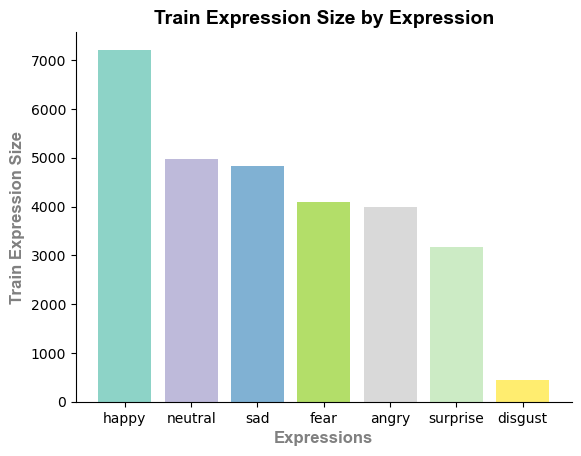

In [9]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "grey", "weight" : "bold", "size" : 12}

sorted_index = np.argsort(train_expression_size)[::-1]

values = np.array(train_expression_size)[sorted_index]
label = np.array(expressions_list)[sorted_index]

colors = plt.cm.Set3(np.linspace(0, 1, len(values)))

plt.bar(label, values, color=colors)

plt.xlabel("Expressions", fontdict=axes_font)
plt.ylabel("Train Expression Size", fontdict=axes_font)
plt.title("Train Expression Size by Expression", fontdict=title_font)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

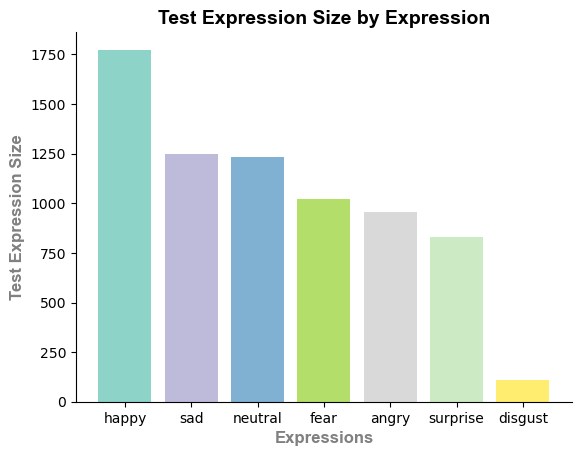

In [10]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "grey", "weight" : "bold", "size" : 12}

sorted_index = np.argsort(test_expression_size)[::-1]

values = np.array(test_expression_size)[sorted_index]
label = np.array(expressions_list)[sorted_index]

colors = plt.cm.Set3(np.linspace(0, 1, len(values)))

plt.bar(label, values, color=colors)

plt.xlabel("Expressions", fontdict=axes_font)
plt.ylabel("Test Expression Size", fontdict=axes_font)
plt.title("Test Expression Size by Expression", fontdict=title_font)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

Let's check one image for each expression to get better understanding of the dataset.

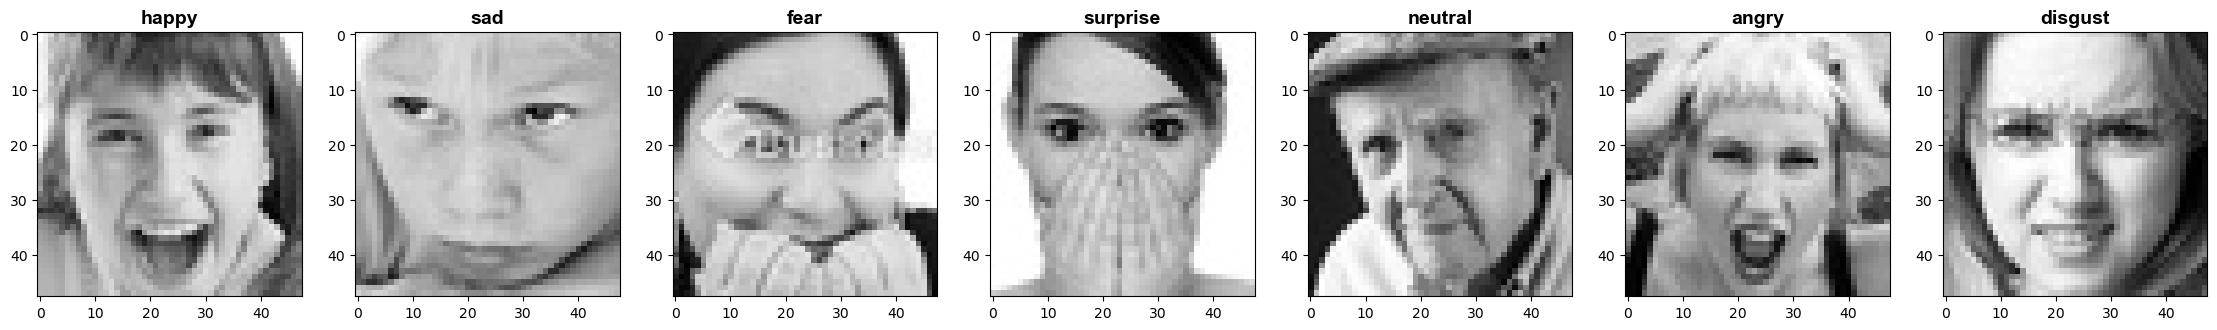

In [11]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}

fig, axes = plt.subplots(1, len(expressions_list), figsize=(len(expressions_list) * 4, 4))

i = 0

while i < len(expressions_list):
    
    expression = expressions_list[i]

    expression_directory = os.path.join(train_directory, expression)
    images_list = os.listdir(expression_directory)
    
    image_directory = os.path.join(expression_directory, random.choice(images_list))
    
    image = cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
        
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(expression, fontdict=title_font)
    
    i += 1

plt.show()

Nice. Let's get deeper to check the images as numpy arrays.

In [12]:
print(f"Images shape is: {image.shape}")

Images shape is: (48, 48)


And for the last step, we want to get assured that all field have the same format type.

In [13]:
formats = []

for dir in [train_directory, test_directory]:

    i = 0

    print(f"Checking {dir.split('/')[1]} data:")
    
    while i < len(expressions_list):
        
        expression = expressions_list[i]

        expression_directory = os.path.join(dir, expression)
        images_list = os.listdir(expression_directory)
        
        for image in images_list:
                    
            format = image.split(".")[1]
            
            if format not in formats:
                formats.append(format)

        print(f"    {expression} Checked.")
        
        i += 1

print("-"*30)
print(f"File formats are: {formats}")

Checking train data:
    happy Checked.
    sad Checked.
    fear Checked.
    surprise Checked.
    neutral Checked.
    angry Checked.
    disgust Checked.
Checking test data:
    happy Checked.
    sad Checked.
    fear Checked.
    surprise Checked.
    neutral Checked.
    angry Checked.
    disgust Checked.
------------------------------
File formats are: ['jpg']


Since everything is ok, we can get further and build a data pypeline.

[Project Content](#0)

## 4. Creating a Data Pipeline to Load The Dataset <a id = 4></a>

First of all, let's create a dataset from image files to use them for training the neural network.</br>
In this step, we also label the data.

In [14]:
data = tf.keras.preprocessing.image_dataset_from_directory(train_directory,
                                                           image_size=(48, 48),
                                                           batch_size=64,
                                                           color_mode="grayscale")

print(f"Data type is:       {type(data)}")

Found 28709 files belonging to 7 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Data type is:       <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


The calsses are assigned like the way below.

In [15]:
expressions_list = data.class_names

expressions_list

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In order to use the data, we should iterate over it using the numpy iterator.

In [16]:
data_iterator = data.as_numpy_iterator()

data_iterator

To use this iterated data, we have to get batch from it to feed the neural network.</br>
This step will be completed in the training stage.

In [17]:
batch = data_iterator.next()

print(f"Each batch has {len(batch)} parts of data.")
print(f"Each batch's images part has the shape of {batch[0].shape}")
print(f"Each batch's images part has the shape of {batch[1].shape}")

Each batch has 2 parts of data.
Each batch's images part has the shape of (64, 48, 48, 1)
Each batch's images part has the shape of (64,)


2023-06-03 07:58:23.515562: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


This means that each batch has two parts of data, images and labels.</br>
Images part has 32 images which are 

Before going further, let's check the train dataset by their labels.

Facial expressions are:
    0. angry
    1. disgust
    2. fear
    3. happy
    4. neutral
    5. sad
    6. surprise


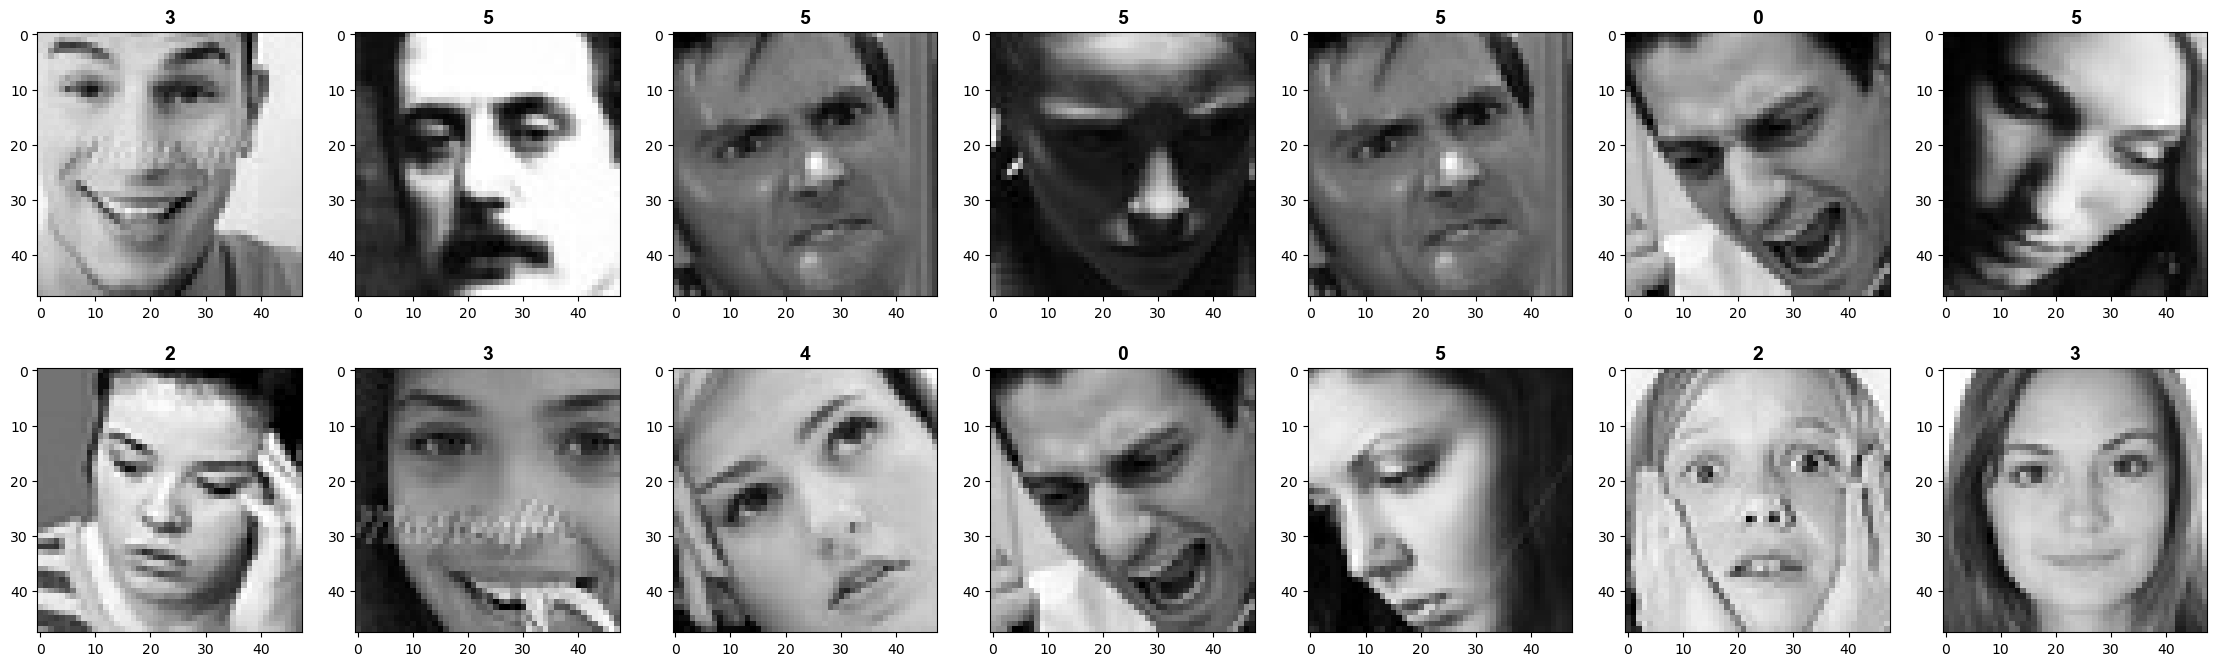

In [18]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}

print("Facial expressions are:")

for expression in expressions_list:
    print(f"    {expressions_list.index(expression)}. {expression}")

indexes = np.random.randint(0, batch[0].shape[0], 14)

fig, axes = plt.subplots(2, 7, figsize=(28, 8))

i = 0
j = 0

for index in indexes:
    
    axes[i, j].imshow(batch[0][index].astype(int), cmap="gray")
    axes[i, j].set_title(batch[1][index], fontdict=title_font)

    j += 1
    
    if j==7:
        i = 1
        j = 0
        
plt.show()

[Project Content](#0)

***

# Second Step: Data Preprocessing

***

## 5. Scaling The Dataset <a id = 5></a>

Firstly, let's check the data values' minimum and maximum.

In [19]:
print(f"Data Minimum: {batch[0].min()}")
print(f"Data Maximum: {batch[0].max()}")

Data Minimum: 0.0
Data Maximum: 255.0


Like most of the times the range of values is between 0 and 255.</br>
Now we can scale the data by deviding its values by 255 to make the learning process faster.

We can do this by using the map function in data pipeline.

In [20]:
data = data.map(lambda x, y: (x/255., y))

Now, we've created the data scaler and the scaler is now embedded in the data pypeline.

Let's check the next batch.

In [21]:
batch = data.as_numpy_iterator().next()

print(f"Data Minimum: {batch[0].min()}")
print(f"Data Maximum: {batch[0].max()}")

Data Minimum: 0.0
Data Maximum: 1.0


As we know, this won't make any change in the images appearance.

[Project Content](#0)

## 6. Splitting The Data <a id = 6></a>

Since the train and validation data is a package of data named train we should split that to validate the model when training it.

In [22]:
train_size = int(len(data)*0.875)
validation_size = int(len(data)*0.125)

print(f"The train dataset size will be {train_size}.")
print(f"The validation dataset size will be {validation_size}.")

The train dataset size will be 392.
The validation dataset size will be 56.


In [23]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)

[Project Content](#0)

***

# Third and The Final Step: Modeling

***

## 7. Defining The Modeling Functions <a id = 7></a>

In order to create a deep neural network, we define a variable taking the whole model in it and then add settings and features to it.

In [24]:
def get_compiled_model(input_shape, optimizer, loss, metrics):
    """
    This is a Python function that compiles and returns a neural network model using the Keras library.

    Args:
        input_shape (tuple)             The shape of the input data for the model.
        optimizer (str or callable)     The optimizer to use for training the model.
        loss (str or callable)          The loss function to use during training.
        metrics (list)                  The list of evaluation metrics for the model.

    Returns:
        model ()                        The compiled Keras model object that can be used for training.
    """
        
    model = Sequential()
    
    # Convolutional and pooling layers
    
    model.add(Conv2D(32, (3, 3), strides=1, activation="relu",
                     padding="same", input_shape=(48, 48, 1)))
    
    model.add(Conv2D(64, (3, 3), strides=1, activation="relu",
                     padding="same"))

    model.add(BatchNormalization())
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))

    # Convolutional and pooling layers
    
    model.add(Conv2D(128, (3, 3), strides=1, activation="relu",
                     padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    
    model.add(Conv2D(256, (3, 3), strides=1, activation="relu",
                     padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    
    model.add(BatchNormalization())
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.25))

    # Flatten and dense layer
    
    model.add(Flatten())
    
    model.add(Dense(256, activation="relu"))
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.25))
    
    # Flatten and dense layer
    
    model.add(Dense(512, activation="relu"))
    
    model.add(BatchNormalization())
    
    model.add(Dropout(0.25))
    
    # Final layer
    
    model.add(Dense(7, activation="softmax"))
    
    # Compiler
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [25]:
def train_model(model, train_data, epochs, validation_data, callbacks):
    """
    Summary:
    This is a Python function that trains a given neural network model
    on the provided training data and returns the training history.

    Args:
        model (tensorflow.keras model)          The neural network model object to train.
        train_data (numpy.ndarray)              The training data to use for training the model.
        train_target (numpy.ndarray)            The target values for the training data.
        epochs (int)                            The number of epochs to train the model.
        validation_data (numpy.ndarray)         The validation data to use for evaluation.
        callbacks (list)                        A list of Keras callbacks to use during training.

    Returns:
        history ()                              The training history object that contains information
                                                about the training and validation metrics over each epoch.
    """

    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=validation_data,
                        callbacks=callbacks,
                        verbose=1)
    
    return history

Here, we define some callbacks to get more insights when training or validating the model.

In [26]:
class TrainingCallbacks(Callback):
    
    def __init__(self):
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        print("Starting training ...")

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        print(f"Epoch {epoch + 1} completed in {elapsed_time:.2f} seconds")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"Training finished in {total_time:.2f} seconds")
        
logs_cb = callbacks.TensorBoard(log_dir="logs")

checkpoint = callbacks.ModelCheckpoint(filepath=os.path.join("checkpoints", "model.h5"),
                                       save_best_only=True,
                                       monitor="val_accuracy")
        
callbacks_list = [TrainingCallbacks(), logs_cb, checkpoint]

[Project Content](#0)

## 8. Building The Model's Architecture <a id = 8></a>

By using the function above, now we can builld the architecture defined in the function and parameters determined as the arguments.

In [27]:
model = get_compiled_model((48, 48, 1),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

It's better to plot the architecture to understand the network better.

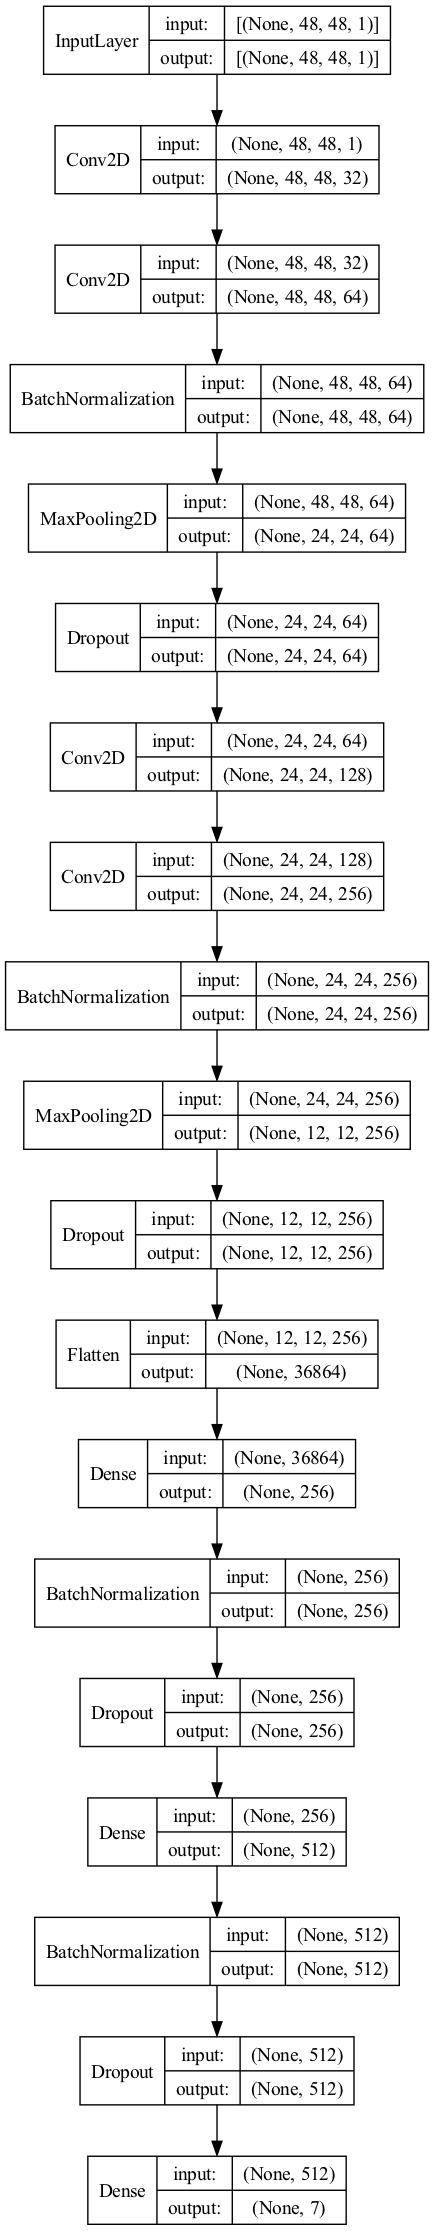

In [28]:
plot_model(model, show_shapes=True,
           show_layer_names=False,
           expand_nested=True,
           rankdir="TB",
           dpi=100)

[Project Content](#0)

## <font color="Red">9. Training <a id = 9></a></font>

<font color="Red"> Now we can train the model and save its information in a variable to check it out later. </font>

In [60]:
history = train_model(model,
                      train_data=train,
                      epochs=60,
                      validation_data=validation,
                      callbacks=callbacks_list)

Starting training ...
Epoch 1/60
  6/392 [..............................] - ETA: 1:09 - loss: 5.4651 - accuracy: 0.1719WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0687s vs `on_train_batch_end` time: 0.0949s). Check your callbacks.


392/392 [==============================] - 91s 230ms/step - loss: 4.4335 - accuracy: 0.2969 - val_loss: 7.5557 - val_accuracy: 0.0815
Epoch 2/60
392/392 [==============================] - 93s 238ms/step - loss: 3.6999 - accuracy: 0.3877 - val_loss: 3.6274 - val_accuracy: 0.3605
Epoch 3/60
392/392 [==============================] - 90s 230ms/step - loss: 3.1953 - accuracy: 0.4369 - val_loss: 3.0575 - val_accuracy: 0.4297
Epoch 4/60
392/392 [==============================] - 87s 223ms/step - loss: 2.7702 - accuracy: 0.4820 - val_loss: 2.6210 - val_accuracy: 0.4958
Epoch 5/60
392/392 [==============================] - 88s 225ms/step - loss: 2.4301 - accuracy: 0.5178 - val_loss: 2.4075 - val_accuracy: 0.4766
Epoch 6/60
392/392 [==============================] - 87s 221ms/step - loss: 2.1455 - accuracy: 0.5585 - val_loss: 2.1967 - val_accuracy: 0.5084
Epoch 7/60
392/392 [==============================] - 85s 217ms/step - loss: 1.9053 - accuracy: 0.5959 - val_loss: 2.0562 - val_accuracy: 0.5

<font color="Red"> In the end, we should save the model's history data in a readable format too. </font>

In [ ]:
with open(os.path.join("history", "history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

[Project Content](#0)

## 10. Loading The Model and its History <a id = 10></a>

Firslty, we open the history file we have saved after training the model.

In [29]:
model = load_model(os.path.join("checkpoints", "model.h5"))

with open(os.path.join("history", "history.pkl"), "rb") as f:
    history = pickle.load(f)

Now we have access the data saved during the training process.

In [30]:
history_df = pd.DataFrame(history)

history_df

,loss,accuracy,val_loss,val_accuracy
0,4.433483,0.296875,7.555721,0.081473
1,3.699945,0.387715,3.627378,0.360491
2,3.195326,0.436862,3.057513,0.429688
3,2.770232,0.482023,2.620952,0.495815
4,2.430101,0.517777,2.407454,0.476562
5,2.145482,0.558474,2.196667,0.508371
6,1.905306,0.595902,2.056201,0.522600
7,1.673164,0.643814,2.058101,0.498605
8,1.485075,0.679169,1.815579,0.570592
9,1.309018,0.720942,1.914467,0.538225


[Project Content](#0)

## 11. Plotting The Models's Loss and Accuracy <a id = 11></a>

Let's check how the model performs in both training and validation datasets through epochs.

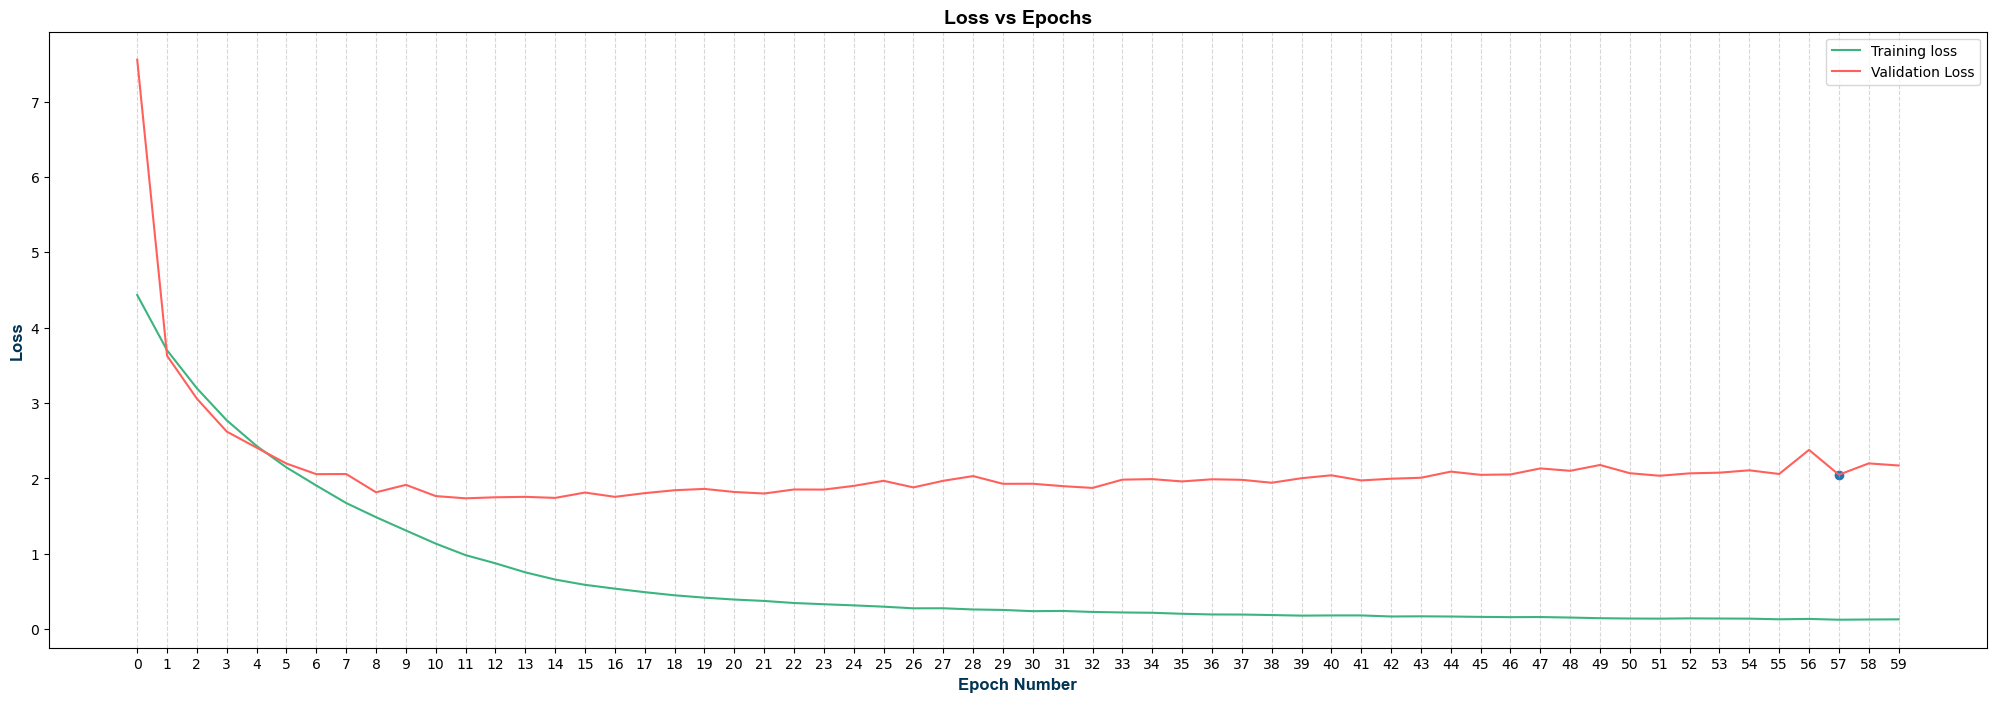

In [31]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "#023553", "weight" : "bold", "size" : 12}

fig = plt.figure(figsize=(25, 8))

plt.plot(history["loss"], color="#3BB47E", label="Training loss")
plt.plot(history["val_loss"], color="#FF605C", label="Validation Loss")

plt.xticks(range(len(history["loss"])))

plt.legend(loc="upper right")

plt.title("Loss vs Epochs", fontdict = title_font)
plt.xlabel("Epoch Number", fontdict = axes_font)
plt.ylabel("Loss", fontdict = axes_font)

plt.grid(True, axis="x", alpha=0.5, linestyle="--")

max_val_acc_row_index = history_df[history_df["val_accuracy"] == max(history_df["val_accuracy"])].index[-1]

plt.scatter(max_val_acc_row_index,
            history_df.loc[max_val_acc_row_index, "val_loss"])

plt.show()

It's obvious that model suffers from overfitting problem.</br>
This can be the result of many issues, which will be addressed later in this notebook.

We can also check its loss values.

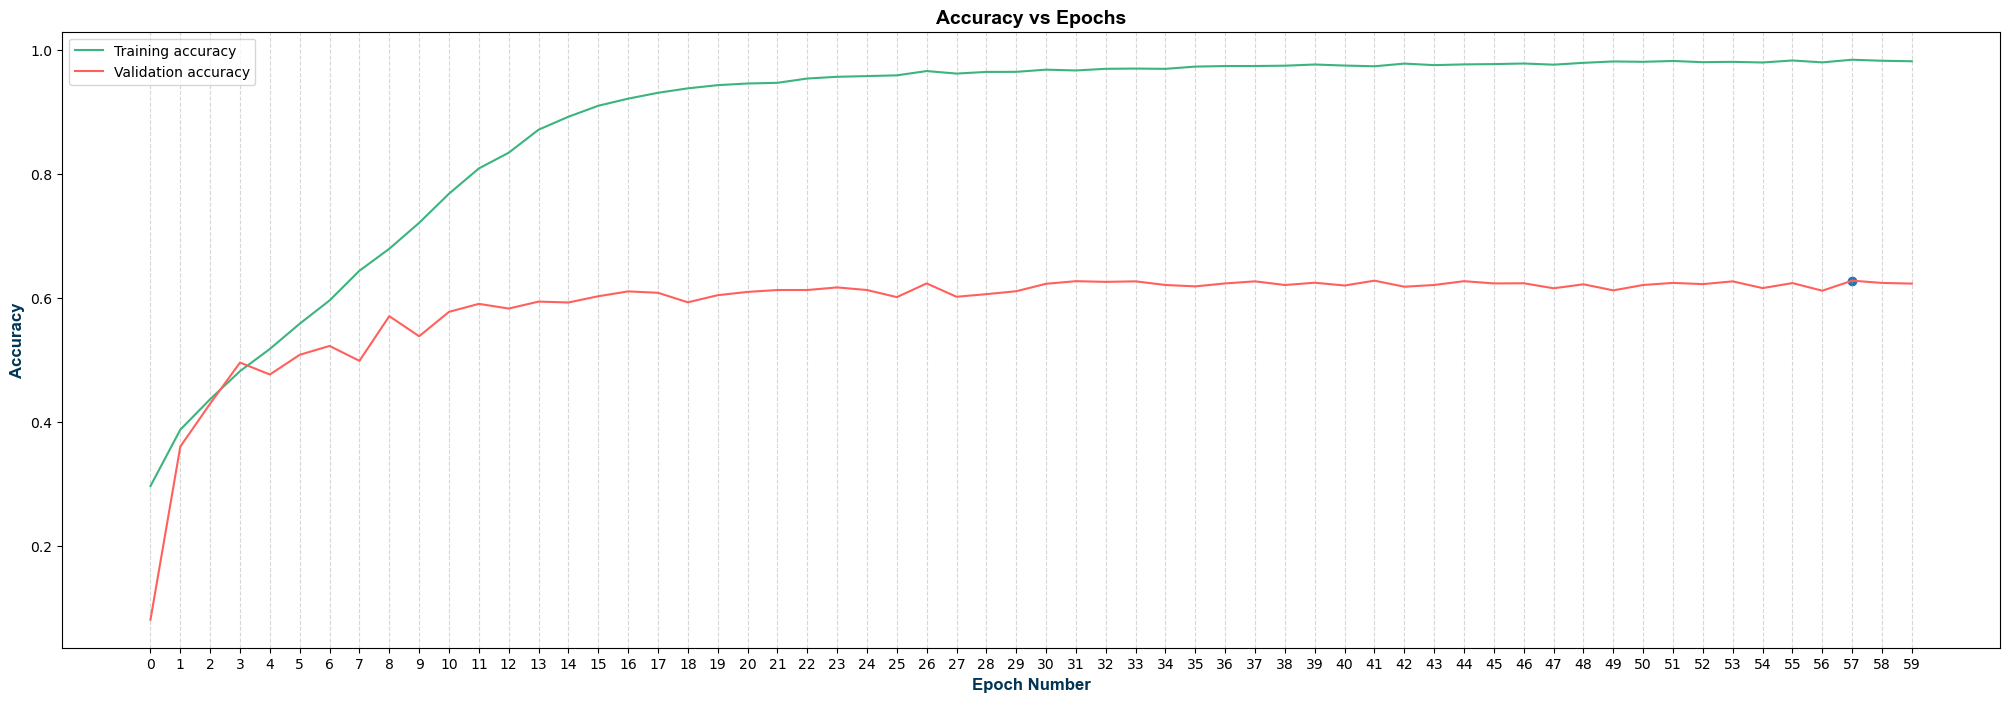

In [32]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "#023553", "weight" : "bold", "size" : 12}

fig = plt.figure(figsize=(25, 8))

plt.plot(history["accuracy"], color="#3BB47E", label="Training accuracy")
plt.plot(history["val_accuracy"], color="#FF605C", label="Validation accuracy")

plt.xticks(range(len(history["accuracy"])))

plt.legend(loc="upper left")

plt.title("Accuracy vs Epochs", fontdict = title_font)
plt.xlabel("Epoch Number", fontdict = axes_font)
plt.ylabel("Accuracy", fontdict = axes_font)

plt.grid(True, axis="x", alpha=0.5, linestyle="--")

plt.scatter(max_val_acc_row_index,
            history_df.loc[max_val_acc_row_index, "val_accuracy"])

plt.show()

[Project Content](#0)

## 12. Model's Performance Evaluation <a id = 12></a>

The last step is to check how the model performs on the testing dataset.</br>
For this goal we will evaluate the model using three metrics.

In [33]:
accuracy = Accuracy()
categorical_accuracy = CategoricalAccuracy()

We haven't load the test dataset in the model, so we should build a data pipeline for that.</br>
And then we should update the metrics for each batch of the test set.

In [34]:
test_directory = os.path.join("data", "test")

test = tf.keras.preprocessing.image_dataset_from_directory(test_directory,
                                                           image_size=(48, 48),
                                                           batch_size=64,
                                                           color_mode="grayscale")

Found 7178 files belonging to 7 classes.


Now we can evaluate the model.

In [35]:
num_classes = 7
confusion_matrix = np.zeros((num_classes, num_classes))

for batch in test.as_numpy_iterator():

    test_data, test_target = batch
    test_target = to_categorical(test_target, num_classes=num_classes)

    test_target_pred = model.predict(test_data, verbose=0)

    categorical_accuracy.update_state(test_target, test_target_pred)
    accuracy.update_state(test_target, test_target_pred)

    test_target_pred_labels = np.argmax(test_target_pred, axis=1)

    batch_confusion_matrix = sk_confusion_matrix(np.argmax(test_target, axis=1), test_target_pred_labels, labels=range(num_classes))
    confusion_matrix += batch_confusion_matrix

Let's check the results.

In [36]:
print("Testing Results")
print("-"*30)

print(f"Accuracy               {(accuracy.result()*100):.4f}")
print(f"Categorical Accuracy   {(categorical_accuracy.result()*100):.4f}")

Testing Results
------------------------------
Accuracy               77.7276
Categorical Accuracy   30.3706


Looking at the testing results, there are a couple of observations:

**Accuracy**</br>

The overall accuracy of 77.7276% indicates that the model is correctly predicting the facial expression for approximately 77.7% of the test samples.</br>
However, it's important to consider the class distribution to gain a deeper understanding of the model's performance.

**Categorical Accuracy**</br>

The categorical accuracy of 30.3706% suggests that the model is struggling to accurately classify the test samples into their respective facial expression categories.</br>
This metric measures the percentage of samples for which the highest predicted class matches the true class.

The low categorical accuracy indicates that the model might be biased towards the majority class(es) or facing difficulties in distinguishing between the different facial expressions, especially the minority classes.

Let's check the confusion matrix to understand how the model performed the predictions.

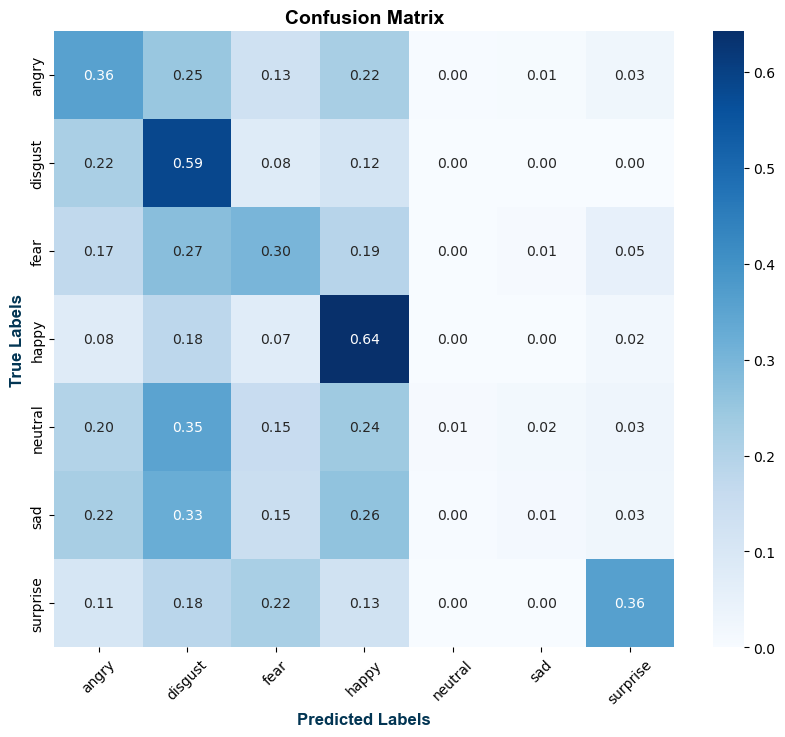

In [37]:
title_font = {"family" : "arial", "color" : "k", "weight" : "bold", "size" : 14}
axes_font = {"family" : "arial", "color" : "#023553", "weight" : "bold", "size" : 12}

normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(normalized_confusion_matrix, annot=True, fmt=".2f", cmap="Blues")

ax.set_xlabel("Predicted Labels", fontdict=axes_font)
ax.set_ylabel("True Labels", fontdict=axes_font)
ax.set_title("Confusion Matrix", fontdict=title_font)

ax.xaxis.set_ticklabels(expressions_list)
ax.yaxis.set_ticklabels(expressions_list)

plt.xticks(rotation=45)

plt.show()

Looking at the confusion matrix, a few observations can be made:

**Majority Class Bias**</br>

The diagonal elements of the confusion matrix (from top left to bottom right) represent the correctly classified samples.</br>
It appears that the model performs relatively well in predicting the "happy" class, as it has the highest percentage (64%) of correct predictions among all the classes.</br>
On the other hand, the model struggles to accurately classify the "neutral" and "sad" classes, as indicated by lower percentages in the corresponding diagonal elements.

**Misclassifications**</br>

The off-diagonal elements of the confusion matrix represent misclassifications.</br>
For example, the model tends to confuse "angry" samples with "disgust," "fear," and "happy" classes.</br>
Similarly, "sad" samples are often misclassified as "angry," "disgust," and "fear."

**Imbalanced Misclassifications**</br>

It's worth noting that the misclassifications are not evenly distributed.</br>
For instance, the "neutral" class has a relatively high proportion of misclassifications, particularly being confused with "disgust," "fear," and "sad."

Based on the confusion matrix, it seems that the model struggles to accurately differentiate between certain facial expressions, especially those with similar visual characteristics.</br>
This highlights the need to further fine-tune the model, consider data augmentation techniques, and potentially explore more complex architectures or advanced techniques to enhance its performance in distinguishing between these classes.

[Project Content](#0)